<hr>
<div style="background-color: lightgray; padding: 20px; color: black;">
<div>
<img src="https://th.bing.com/th/id/R.3cd1c8dc996c5616cf6e65e20b6bf586?rik=09aaLyk4hfbBiQ&riu=http%3a%2f%2fcidics.uanl.mx%2fwp-content%2fuploads%2f2016%2f09%2fcimat.png&ehk=%2b0brgMUkA2BND22ixwLZheQrrOoYLO3o5cMRqsBOrlY%3d&risl=&pid=ImgRaw&r=0" style="float: right; margin-right: 30px;" width="200"/> 
<font size="6.5" color="8C3061"><b>Métodos Iterativos para Problemas Inversos </b></font> <br>
<font size="5.5" color="8C3061"><b>Problemas Inversos - Tarea 2 </b></font> 
</div>
<div style="text-align: left">  <br>
Edison David Serrano Cárdenas. <br>
MSc en Matemáticas Aplicadas <br>
CIMAT - Sede Guanajuato <br>
</div>

</div>
<hr>


*Cargar librerias:*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale,iradon_sart

import seaborn as sns
sns.set_theme(style="whitegrid")

np.random.seed(14)

## <font color="8C3061" >**Implementación del Problema de Convolución**</font> 

In [22]:
class forward_maping:
    def __init__(self, n=100, gamma=0.025, SNR=100.0):
        self.n = n                  
        self.gamma = gamma  # standard deviation of the Gaussian kernel
        self.SNR = SNR      # Signal to noise ratio
        self.c = 1.0/(np.sqrt(gamma**2*2*np.pi))   # Normalization constant
        self.h = 1.0/n      # Grid spacing
        
        # Construct operator matrix
        self.x = np.linspace(0,1,n)
        self.K =  self.c*self.h*np.exp((-1/(2*gamma**2))*np.power(np.subtract.outer(self.x,self.x),2))
        self.make_data()
        
        # Singular value decomposition
        self.s= np.linalg.svd(self.K,compute_uv=False)

        
    def f_true(self, x):
        x = np.asarray(x)  # Ensure x is a NumPy array for vectorized operations
        result = np.where((0.1 < x) & (x < 0.25), 0.75,
                np.where((0.3 < x) & (x < 0.32), 0.25,
                np.where((0.5 < x) & (x < 1), np.sin(2 * np.pi * x)**4, 0)))
        
        return result
    
    def make_data(self):
        self.y = self.f_true(self.x) # f
        self.z = np.dot(self.K,self.y) # Kf
        
        self.eta = np.max(self.z)/self.SNR # standard deviation
        self.z_noisy = self.z + self.eta*np.random.normal(size=self.n) # Kf+n
        self.noise_level = np.linalg.norm(self.z_noisy-self.z)
            
        
    def solve_landweber(self,x0=None,tol=None,beta = None, max_iter = 1000):
        if x0 is None:
            x0 = np.zeros(self.n)
        if tol is None:
            tol = self.noise_level
        if beta is None:
            beta = 2*0.5/self.s[0]
        
        k = 0
        while k < max_iter:
            # Landweber iteration
            x0 = x0 + beta*self.K.T@(self.z_noisy-self.K@x0)
            data_error = np.linalg.norm(self.K @ x0-self.z_noisy)
            # Discrepancy principle
            if data_error < tol:
                print('Converged in',k,'iterations')
                print('Error:',round(data_error,5))
                return x0
            k += 1
            
        print('Not converged')
        return x0
    
    def solve_Kaczmarz(self,x0=None,tol=None,max_iter = 1000):
        if x0 is None:
            x0 = np.zeros(self.n)
        if tol is None:
            tol = self.noise_level
        
        k = 0
        while k < max_iter:
            index = np.random.randint(self.n)
            x0 = x0 + (self.z_noisy[index]-self.K[index]@x0)/(self.K[index]@self.K[index])*self.K[index]
            data_error = np.linalg.norm(self.K @ x0-self.z_noisy)
            # Discrepancy principle
            if data_error < tol:
                print('Converged in',k,'iterations')
                print('Error:',round(data_error,5))
                return x0
            k += 1
            
        print('Not converged')
        return x0
    
    def plot(self,predictions,names,colors= ['#B1C29E','#71BBB2','#DD88CF'],save=False):
        
        plt.figure(figsize=(15,4))

        plt.plot(self.x,self.y,
                 label='$f_{true}$',color='#497D74',
                 marker='o',markersize=4,
                 alpha = 0.4)
        
        for pred,name,color in zip(predictions,names,colors):
            plt.plot(self.x,pred,label=name,color=color,alpha =0.6)

        plt.legend(fontsize=6.5)
        plt.ylabel(r'$f_\alpha(x)$')
        plt.xlabel(r'$x$')
        if save:
            plt.savefig('fm_'+name+'.png',dpi=300)

        plt.legend()
        plt.show()

## <font color="8C3061" >**Método de Landweber**</font> 

In [23]:
fmap = forward_maping(n=100)

In [24]:
sol_landwebwer = fmap.solve_landweber()

Converged in 16 iterations
Error: 0.1045


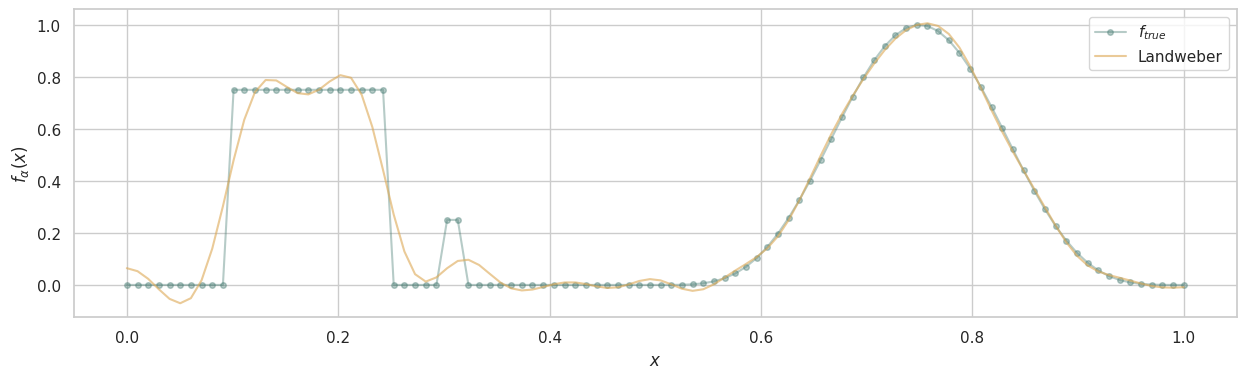

In [18]:
fmap.plot([sol_landwebwer],[r'Landweber'],colors=['#DDA853'],save=True)

## <font color="8C3061" >**Método de Kaczmarz**</font> 

In [25]:
sol_kaczmarz = fmap.solve_Kaczmarz()

Not converged


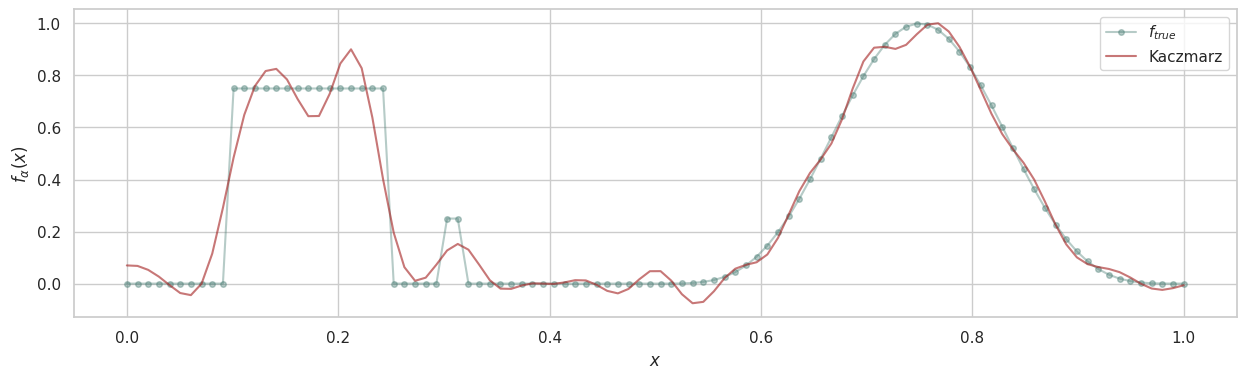

In [20]:
fmap.plot([sol_kaczmarz],[r'Kaczmarz'],colors=['#A31D1D'],save=True)

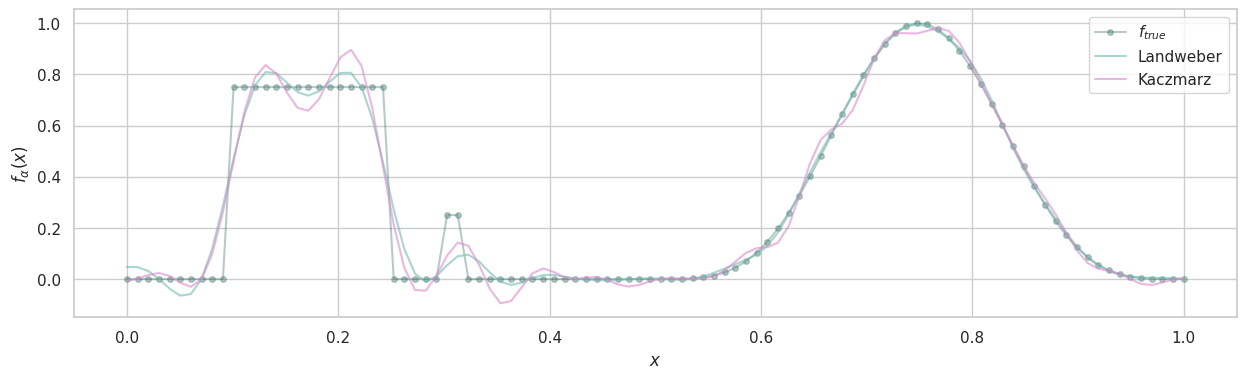

In [26]:
fmap.plot([sol_landwebwer,sol_kaczmarz],[r'Landweber',r'Kaczmarz'],colors=['#71BBB2','#DD88CF'],save=True)

## <font color="8C3061" >**Tomografía Computarizada**</font> 

### <font color="8C3061" >**Senograma**</font> 

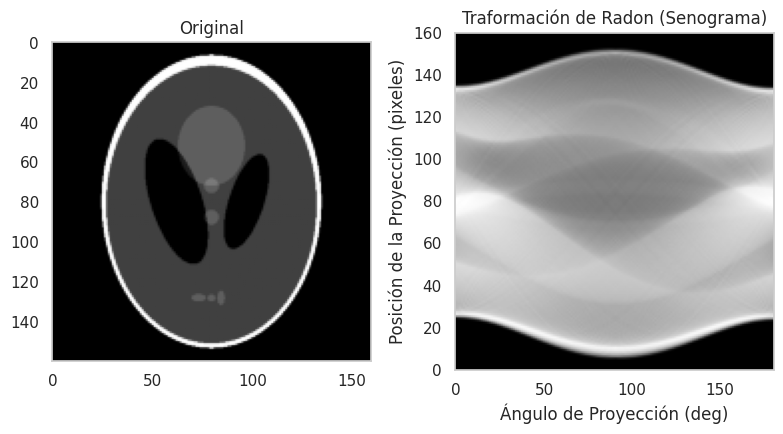

In [10]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', channel_axis=None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)
ax1.grid(False)
theta = np.linspace(0.0, 180.0, max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]

ax2.set_title("Traformación de Radon (Senograma)")
ax2.set_xlabel("Ángulo de Proyección (deg)")
ax2.set_ylabel("Posición de la Proyección (pixeles)")
ax2.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
    aspect='auto',
)
ax2.grid(False)
fig.tight_layout()
plt.savefig('radon_transform.pdf',dpi=300)
plt.show()

https://scikit-image.org/docs/0.24.x/auto_examples/transform/plot_radon_transform.html#id5

### <font color="8C3061" >**Reconstrucción de la Imagen**</font> 

SART (1 iteration) rms reconstruction error: 0.0329
SART (2 iterations) rms reconstruction error: 0.0214


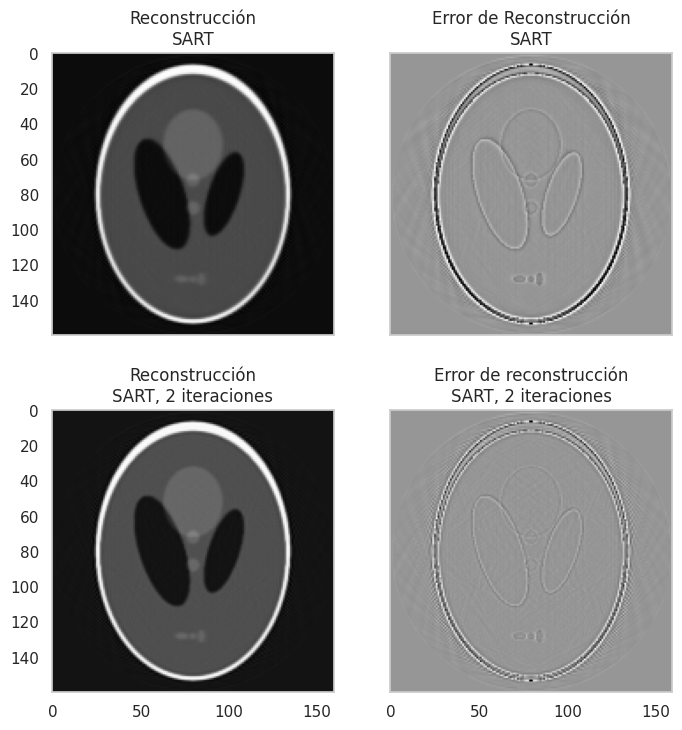

In [11]:
imkwargs = dict(vmin=-0.2, vmax=0.2)

reconstruction_sart = iradon_sart(sinogram, theta=theta)
error = reconstruction_sart - image
print(
    f'SART (1 iteration) rms reconstruction error: ' f'{np.sqrt(np.mean(error**2)):.3g}'
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstrucción\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[1].set_title("Error de Reconstrucción\nSART")
ax[1].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r, **imkwargs)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta, image=reconstruction_sart)
error = reconstruction_sart2 - image
print(
    f'SART (2 iterations) rms reconstruction error: '
    f'{np.sqrt(np.mean(error**2)):.3g}'
)

ax[2].set_title("Reconstrucción\nSART, 2 iteraciones")
ax[2].imshow(reconstruction_sart2, cmap=plt.cm.Greys_r)

ax[3].set_title("Error de reconstrucción\nSART, 2 iteraciones")
ax[3].imshow(reconstruction_sart2 - image, cmap=plt.cm.Greys_r, **imkwargs)
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)
plt.savefig('radon_reconstruction.pdf',dpi=300)
plt.show()
